<a href="https://colab.research.google.com/github/ravadhani/NLP/blob/main/NER_PharmaCaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [3]:
#check if GPU is available, then the set of hyperparametes to be used
if tf.test.is_gpu_available():
  BATCH_SIZE = 512  #number of examples used in iteration
  EPOCHS = 5  #number of passes through the entire dataset
  MAX_LEN = 75  #max length of review (in words)
  EMBEDDING = 40  #Dimension of word embedding vector
#if the required GPU is not available then the set of Hyper parameters for CPU training
else:
  BATCH_SIZE = 32
  EPOCHS = 5
  MAX_LEN = 75
  EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Loading Dataset

In [4]:
!gdown 1ao5aINQqedAWHSXGLpAVzW1iEZj7sZ5_
!gdown 15RuVEDqO592th-44iVEpcGbtvX9RjDWR

Downloading...
From: https://drive.google.com/uc?id=1ao5aINQqedAWHSXGLpAVzW1iEZj7sZ5_
To: /content/ner_dataset.csv
100% 15.2M/15.2M [00:00<00:00, 52.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=15RuVEDqO592th-44iVEpcGbtvX9RjDWR
To: /content/drugsComTrain_raw.csv
100% 1.38M/1.38M [00:00<00:00, 106MB/s]


In [5]:
df = pd.read_csv("/content/ner_dataset.csv", encoding = 'latin1')
df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


If you have checked the csv file, you will notice that each sentence is alsready split into words and each row belongs to a word. The Sentence: 1 you see at row '0' is the start of sentence 1 words. Rest all have NaN until sentence 2 starts.
So, let us fill up the NaN with the values from the respective sentence.

In [6]:
df = df.fillna(method = 'ffill')
df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Looking at the dataframe, we see that it has 4 columns.


  *   Sentence #(the sentence number)
  *   Word
  *   POS (Parts of Speech)
  *   Tag (annotation which is manually labelled against each word)

This method of labelling is called Sequence labelling.

Observe and understand the data.





In [7]:
df.shape

(1048575, 4)

In [8]:
print("Number of sentences: ", len(df.groupby(['Sentence #'])))

Number of sentences:  47959


In [9]:
unique_words = list(set(df['Word'].values))
n_words = len(unique_words)
print("Number of unique words in the dataset: ", n_words)

Number of unique words in the dataset:  35177


In [10]:
n_tags = len(df.groupby(['Tag']))
print("Number of Tags/labels: ", n_tags)

Number of Tags/labels:  17


In [11]:
tags = list(set(df['Tag'].values))
print("Tags: ", tags)

Tags:  ['B-tim', 'I-art', 'I-gpe', 'B-geo', 'B-org', 'I-org', 'I-per', 'O', 'I-nat', 'B-art', 'B-nat', 'I-eve', 'B-per', 'I-geo', 'B-gpe', 'I-tim', 'B-eve']



- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon


In [12]:
#Frequency of each Tag
df['Tag'].value_counts()

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

**Geographic location** has the maximum frequency , followed by **Time entity**
(We can ignore O as it represents other words like - of, it, to, thousand..etc)

Training an **NER** model expects input data in the form of token sequences paired with POS and NER tags.

The below class **SentenceGetter** streamlines the process of extracting sentences from a DataFrame and formatting them into a sequence suitable for training NER models, enabling efficient data preparation for machine learning tasks like NER.

In [13]:
class SentenceGetter(object):
  """Class to Get the sentence in this format:
  [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_n, Tag_n)]"""
  def __init__(self, data):
    """Args: data is the pandas dataframe "df" which contains the dataset"""
    self.n_sent = 1
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w,p,t) for w, p, t in zip(s['Word'].values.tolist(),
                                                     s['POS'].values.tolist(),
                                                     s['Tag'].values.tolist())]
    #grouping by the column "Sentence #" and applying the above lanbda functions for each group
    self.grouped = self.data.groupby('Sentence #').apply(agg_func)
    self.sentences = [s for s in self.grouped]

  def get_next(self):
    """Return one sentence"""
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      return None

getter = SentenceGetter(df)
sent = getter.get_next()
print("This is a sample of how the sentence looks after formatting in a sequence tuple format:")
print(sent)

This is a sample of how the sentence looks after formatting in a sequence tuple format:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


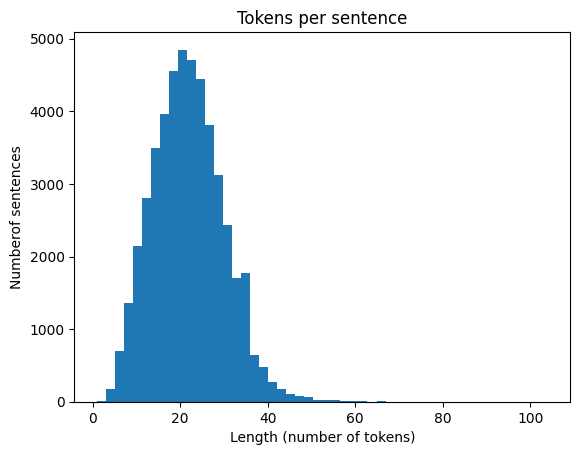

In [14]:
#get all formatted sentences

sentences = getter.sentences
#plot the sentence by their length
plt.hist([len(s) for s in sentences], bins = 50)
plt.title('Tokens per sentence')
plt.xlabel('Length (number of tokens)')
plt.ylabel("Numberof sentences")
plt.show()

From the above plot, we can see that most of the sentences have **tokens** in the range **15-30**. Token here are words ignoring the punctuation marks.

Further pre-processing:

*   We can convert each text word to a corresponding integer ID using the **word2idx dictionary**. This saves a lot a memory
*   To feed the data to our BI-LSTM-CRF model, we need to ensure that all text is of same length
    *   Using **sequence.pad_sequences()** and variable **MAX_LEN** to achieve the same length input.
    *   Text that is shorter that MAX_LEN gets added with the padding(given padding) to get to MAX_LEN, where as text longer than MAX_LEN gets truncated to fit that length.





In [15]:
import sklearn

# generating integer Id for all unique words
#vocabulary key:word -> value:token_index
#the first 2 entries are reserved for PAD and UNK
word2idx = {w: i+2 for i, w in enumerate(unique_words)}  # words - is the list of unique words we got from earlier
word2idx['PAD'] = 0  #for Padding
word2idx['UNK'] = 1  #for unknnown words
#vocabulary key:token_index -> value:word
idx2word = {i: w for w, i in word2idx.items()}

#generating integer Id for all Tags
#vocabulary key:tag/label -> value:tag_index
#the first entity is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx['PAD'] = 0
#vocabulary key:tag_index -> value:tag/label
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx['Obama']))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


The word Obama is identified by the index: 7458
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 4


In [16]:
pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [17]:
from keras_preprocessing.sequence import pad_sequences

#convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]

#padding each sentence to have same length
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

#convert tag/label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]

#padding each sentence to have same length
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

#one-hot encoding for the target variable(tag in this case)
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  #n_tags+1(PAD)

#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [18]:
X_train.shape, X_test.shape, np.array(y_train).shape, np.array(y_test).shape

print('Raw Sample:\n ', ' '.join([w[0] for w in sentences[0]]))
print('\n ')
print('Raw Label:\n ', ' '.join([w[2] for w in sentences[0]]))
print('\n ')
print('After processing, sample:\n', X[0])
print('\n ')
print('After processing, sample:\n', y[0])

Raw Sample:
  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

 
Raw Label:
  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O

 
After processing, sample:
 [ 4713  6407 17324  8687  4636 29664 11558  5609 24224  8518 31867  1154
  4761 23788 14563  8518 30046  6407  3629 15568  8103 15718 34552 26810
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, sample:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [19]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.4 MB/s eta 0:00:00


In [20]:
pip install tensorflow

In [21]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.layers import CRF

#model definition
input = Input(shape = (MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING,  #n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input) #default: 20-dimension embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  #variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  #a dense layer with Relu activation
crf = CRF(n_tags+1)  # CRF layer , n_tags+1 (for PAD)
out = crf(model)  #output

model = Model(input, out)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')
model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding (Embedding)       (None, 75, 20)            703580    
                                                                 
 bidirectional (Bidirection  (None, 75, 100)           28400     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 75, 50)            5050      
 ributed)                                                        
                                                                 
 crf (CRF)                   [(None, 75),              1278      
                              (None, 75, 18),                    
                              (None,),                       

**Case Study:**
To identify side effects/problems/diseases assiciated with drugname in a review.

**How to do:**

A regular NER model cannot be used as Named Entity Recognition is more of domain specific nature. There are domain specific NERs such as banking, e-commerce, manufacturing, bio-medical NER.

In out case we can use **Stanza** - a Bio-Medical NER

Stanza currently provides packages that support Universal Dependencies (UD)-compatible syntactic analysis and named entity recognition (NER) from both English biomedical literature and clinical note text. Officially offered packages include:

2 UD-compatible biomedical syntactic analysis pipelines, trained with human-annotated treebanks;
1 UD-compatible clinical syntactic analysis pipeline, trained with silver data

In [29]:
raw_df=pd.read_csv('/content/drugsComTrain_raw.csv', encoding='iso-8859-1')
raw_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461.0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,20-May-12,27.0
1,95260.0,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,27-Apr-10,192.0
2,92703.0,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,14-Dec-09,17.0
3,138000.0,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,03-Nov-15,10.0
4,35696.0,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,27-Nov-16,37.0


In [30]:
print('Review Number:',raw_df['uniqueID'][0])
print('Drug Name:',raw_df['drugName'][0])
print('Review:',raw_df['review'][0])

Review Number: 206461.0
Drug Name: Valsartan
Review: "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"


In [31]:
print('Review Number:',raw_df['uniqueID'][15])
print('Drug Name:',raw_df['drugName'][15])
print('Review:',raw_df['review'][15])

Review Number: 81890.0
Drug Name: Liraglutide
Review: "I have been taking Saxenda since July 2016.  I had severe nausea for about a month once I got up to the 2.6 dosage.  It has since subsided and the only side effect I notice now is the dry mouth.  I make sure to drink  2.5 litres of water a day (about 10 glasses).  This helps with the weight loss as well as the constipation.  I have been reducing my dose to find a comfortable spot where I am still losing weight but don&#039;t feel like I am over medicating.  For me, 1.8 is working very well.  I also feel wearing a Fitbit has really helped.  I can track my food, water, exercise and steps - it keeps me moving more.  When this started I could barely walk the length of myself without getting winded - I have lost 58 lbs so far."


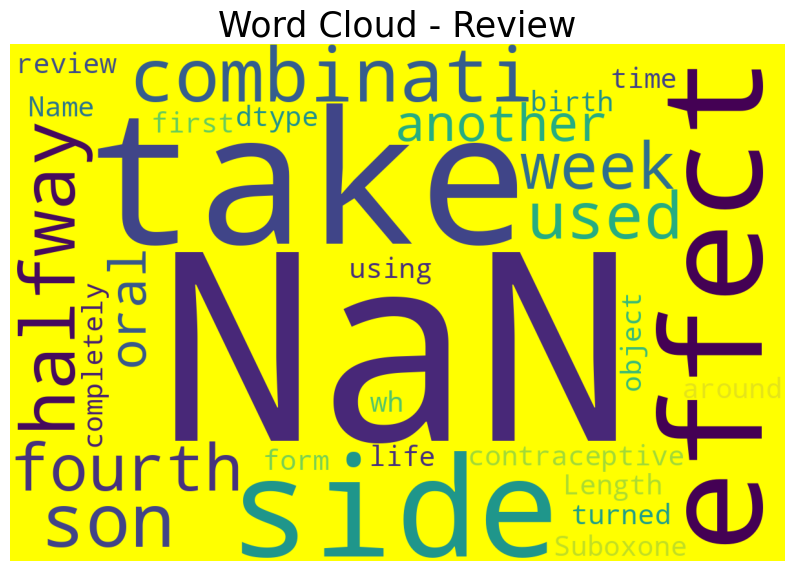

In [32]:
#word cloud for the reviews
#most popular drugs
from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'yellow', stopwords = stopwords, width = 1200, height = 800).generate(str(raw_df['review']))

plt.rcParams['figure.figsize'] = (10, 15)
plt.title('Word Cloud - Review', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

The above word cloud doesn't give much information. We need a model which is pre-trained on Bio-Medical data and would be able to identify drug names and side-effects/symptioms and disease name.

We can use Stanza for this. Stanza is a natural language processing (NLP). It provides a wide range of pre-trained models and tools for various NLP tasks, such as tokenization, part-of-speech tagging, named entity recognition (NER), dependency parsing, and more

In [22]:
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many


**i2b2 NER model:**
This model can identify various medical entities such as problem mentions (e.g., diseases, symptoms),
 treatment procedures, and tests mentioned in clinical narratives.

**bc5cdr NER Model:**
 This model is trained to extract information related to chemical-disease relationships, pharmacogenomics, and other biomedical applications where chemical and disease entities are crucial.

In [25]:
import stanza
stanza.download('en', package='mimic', processors={'ner':'i2b2'})
stanza.download('en', package='mimic', processors={'ner':'bc5cdr'})


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | i2b2           |
| forward_charlm  | mimic          |
| pretrain        | mimic          |
| backward_charlm | mimic          |

INFO:stanza:File exists: /root/stanza_resources/en/tokenize/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/pos/mimic_charlm.pt
INFO:stanza:File exists: /root/stanza_resources/en/lemma/mimic_nocharlm.pt
INFO:stanza:File exists: /root/stanza_resources/en/depparse/mimic_charlm.pt
INFO:stanza:File exists: /root/stanza_resources/en/ner/i2b2.pt
INFO:stanza:File exists: /root/stanza_resources/en/forward_charlm/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package        |
------------------------------------
| tokenize        | mimic          |
| pos             | mimic_charlm   |
| lemma           | mimic_nocharlm |
| depparse        | mimic_charlm   |
| ner             | bc5cdr         |
| pretrain        | mimic          |
| backward_charlm | pubmed         |
| forward_charlm  | pubmed         |
| backward_charlm | mimic          |
| forward_charlm  | mimic          |
| pretrain        | biomed         |

INFO:stanza:File exists: /root/stanza_resources/en/tokenize/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/pos/mimic_charlm.pt
INFO:stanza:File exists: /root/stanza_resources/en/lemma/mimic_nocharlm.pt
INFO:stanza:File exists: /root/stanza_resources/en/depparse/mimic_charlm.pt
INFO:stanza:File exists: /root/stanza_resources/en/ner/bc5cdr.pt
INFO:stanza:F

In [26]:
nlp1 = stanza.Pipeline('en', package='mimic', processors={'ner':'i2b2'})
nlp2 = stanza.Pipeline('en', package='mimic', processors={'ner':'bc5cdr'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | mimic          |
| pos       | mimic_charlm   |
| lemma     | mimic_nocharlm |
| depparse  | mimic_charlm   |
| ner       | i2b2           |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | mimic          |
| pos       | mimic_charlm   |
| lemma     | mimic_nocharlm |
| depparse  | mimic_charlm   |
| ner       | bc5cdr         |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [27]:
#check a sample sentence with i2b2 model
doc = nlp1("This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch")
doc.entities

[{
   "text": "birth control",
   "type": "TREATMENT",
   "start_char": 40,
   "end_char": 53
 },
 {
   "text": "the patch",
   "type": "TREATMENT",
   "start_char": 81,
   "end_char": 90
 },
 {
   "text": "my cramps",
   "type": "PROBLEM",
   "start_char": 305,
   "end_char": 314
 },
 {
   "text": "cramps",
   "type": "PROBLEM",
   "start_char": 372,
   "end_char": 378
 },
 {
   "text": "birth control",
   "type": "TREATMENT",
   "start_char": 392,
   "end_char": 405
 },
 {
   "text": "the patch",
   "type": "TREATMENT",
   "start_char": 437,
   "end_char": 446
 }]

In [28]:
#check a sample sentence with i2b2
doc = nlp2("This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch")
doc.entities

[{
   "text": "cramps",
   "type": "DISEASE",
   "start_char": 308,
   "end_char": 314
 },
 {
   "text": "cramps",
   "type": "DISEASE",
   "start_char": 372,
   "end_char": 378
 }]

We see almost same results with both models, just the name of the entities differ.

Choosing **bc5cdr** model going forward

In [37]:
#slicing the first 50 rows

df_med = raw_df.head(50)
df_med['Side-Effects'] = ''

for i, row in df_med.iterrows():
  doc = nlp2(row['review'])
  doc_entity = doc.entities
  ae = []

  for token in doc_entity:
    if token.type == 'DISEASE':
      ae.append(token.text)
  # .at accessor in pandas is used to access a single value in a DataFrame at a specific row
  # and column. It provides a way to access and modify DataFrame values by
  #label (index label and column label).
  df_med.at[i, 'Side-Effects'] = ae

<ipython-input-37-72b27ed0462c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_med['Side-Effects'] = ''


In [38]:
df_med.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,Side-Effects
0,206461.0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,20-May-12,27.0,[]
1,95260.0,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,27-Apr-10,192.0,[]
2,92703.0,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,14-Dec-09,17.0,[]
3,138000.0,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,03-Nov-15,10.0,"[cramps, cramps]"
4,35696.0,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,27-Nov-16,37.0,[constipation]


We can see that Side Effects columns has been populated with relavant problems/diseases.

We can now extract only the relevant information we need for this case study of tagging drug with the side-effects

In [40]:
#extracting the columns we need and filtering only rows that have non null side-effects
cols_needed = ['drugName', 'Side-Effects']
df_rel = df_med.loc[:, cols_needed]
df_rel = df_rel[df_rel['Side-Effects'].astype(bool)]
df_rel.head()

,drugName,Side-Effects
3,Ortho Evra,"[cramps, cramps]"
4,Buprenorphine / naloxone,[constipation]
5,Cialis,[headache]
7,Aripiprazole,"[depression, depressed, Bi-polar disorder]"
9,Ethinyl estradiol / levonorgestrel,"[acne, acne, depression, weight gain, depressed]"


In [41]:
# Create a list of tuples containing (drugName, side effect)
result_list = [(row['drugName'], side_effect)
               for _, row in df_rel.iterrows()
               for side_effect in row['Side-Effects']]


In [42]:
result_list

[('Ortho Evra', 'cramps'),
 ('Ortho Evra', 'cramps'),
 ('Buprenorphine / naloxone', 'constipation'),
 ('Cialis', 'headache'),
 ('Aripiprazole', 'depression'),
 ('Aripiprazole', 'depressed'),
 ('Aripiprazole', 'Bi-polar disorder'),
 ('Ethinyl estradiol / levonorgestrel', 'acne'),
 ('Ethinyl estradiol / levonorgestrel', 'acne'),
 ('Ethinyl estradiol / levonorgestrel', 'depression'),
 ('Ethinyl estradiol / levonorgestrel', 'weight gain'),
 ('Ethinyl estradiol / levonorgestrel', 'depressed'),
 ('Topiramate', 'headaches'),
 ('Topiramate', 'migraines'),
 ('Topiramate', 'weight loss'),
 ('L-methylfolate', 'pain'),
 ('L-methylfolate', 'depression'),
 ('Pentasa', 'body aching'),
 ('Pentasa', 'fatigue'),
 ('Pentasa', 'heart palpitations'),
 ('Pentasa', 'arrhythmias'),
 ('Dextromethorphan', 'cough'),
 ('Dextromethorphan', 'cough'),
 ('Dextromethorphan', 'stomach cramps'),
 ('Dextromethorphan', 'diarrhea'),
 ('Dextromethorphan', 'cough'),
 ('Nexplanon', 'acne'),
 ('Liraglutide', 'nausea'),
 ('Lira

In [43]:
#convert the list into a dataframe
df_drug_problem = pd.DataFrame(result_list,columns = ['drugName', 'Side-Effects'])
df_drug_problem.head(10)

,drugName,Side-Effects
0,Ortho Evra,cramps
1,Ortho Evra,cramps
2,Buprenorphine / naloxone,constipation
3,Cialis,headache
4,Aripiprazole,depression
5,Aripiprazole,depressed
6,Aripiprazole,Bi-polar disorder
7,Ethinyl estradiol / levonorgestrel,acne
8,Ethinyl estradiol / levonorgestrel,acne
9,Ethinyl estradiol / levonorgestrel,depression


In [44]:
#dropping the duplicates from the above dataframe
df_drug_problem.drop_duplicates(subset=None, keep='first', inplace=False)

,drugName,Side-Effects
0,Ortho Evra,cramps
2,Buprenorphine / naloxone,constipation
3,Cialis,headache
4,Aripiprazole,depression
5,Aripiprazole,depressed
...,...,...
105,Tamsulosin,Memory problems
106,Tamsulosin,runny nose
107,Tamsulosin,weakness
108,Tamsulosin,tiredness


In [45]:
df_drug_problem['drugName'].value_counts()

drugName
Lamotrigine                           8
Trazodone                             8
Tamsulosin                            7
Dulcolax                              6
Amitriptyline                         6
Ethinyl estradiol / levonorgestrel    5
Ledipasvir / sofosbuvir               5
Dextromethorphan                      5
Azithromycin                          4
Toradol                               4
Pentasa                               4
Liraglutide                           4
Atripla                               3
Trimethoprim                          3
Sertraline                            3
Contrave                              3
Topiramate                            3
Aripiprazole                          3
Imitrex                               3
Fluconazole                           2
Trilafon                              2
MoviPrep                              2
Ortho Evra                            2
Daytrana                              2
L-methylfolate                 

So we see the top 5 drugName with the highest number of side-effects are :

*   Trazodone
*   Lamotrigine
*   Tamsulosin
*   Amitriptyline
*   Dulcolax
